# Test Unfold 5D
Test program for the classes TUnfoldDensity and TUnfoldBinning.

A toy test of the TUnfold package

This is an example of unfolding a two-dimensional distribution
also using an auxiliary measurement to constrain some background

The example comprises several macros
  testUnfold5a.C   create root files with TTree objects for
                     signal, background and data
           -> write files  testUnfold5_signal.root
                           testUnfold5_background.root
                           testUnfold5_data.root

  testUnfold5b.C   create a root file with the TUnfoldBinning objects
           -> write file  testUnfold5_binning.root

  testUnfold5c.C   loop over trees and fill histograms based on the
                     TUnfoldBinning objects
           -> read  testUnfold5_binning.root
                    testUnfold5_signal.root
                    testUnfold5_background.root
                    testUnfold5_data.root

           -> write testUnfold5_histograms.root

  testUnfold5d.C   run the unfolding
           -> read  testUnfold5_histograms.root
           -> write testUnfold5_result.root
                    testUnfold5_result.ps


 **Version 17.6, in parallel to changes in TUnfold**

#### History:
 - Version 17.5, in parallel to changes in TUnfold
 - Version 17.4, in parallel to changes in TUnfold
 - Version 17.3, in parallel to changes in TUnfold
 - Version 17.2, in parallel to changes in TUnfold
 - Version 17.1, in parallel to changes in TUnfold
 - Version 17.0 example for multi-dimensional unfolding

 This file is part of TUnfold.

 TUnfold is free software: you can redistribute it and/or modify
 it under the terms of the GNU General Public License as published by
 the Free Software Foundation, either version 3 of the License, or
 (at your option) any later version.

 TUnfold is distributed in the hope that it will be useful,
 but WITHOUT ANY WARRANTY; without even the implied warranty of
 MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
 GNU General Public License for more details.

 You should have received a copy of the GNU General Public License
 along with TUnfold.  If not, see <http://www.gnu.org/licenses/>.



**Author:** Stefan Schmitt DESY, 14.10.2008  
<i><small>This notebook tutorial was automatically generated with <a href= "https://github.com/root-project/root/blob/master/documentation/doxygen/converttonotebook.py">ROOTBOOK-izer</a> from the macro found in the ROOT repository  on Thursday, August 29, 2019 at 04:01 AM.</small></i>

In [1]:
%%cpp -d
#include <iostream>
#include <cmath>
#include <map>
#include <TMath.h>
#include <TCanvas.h>
#include <TStyle.h>
#include <TGraph.h>
#include <TFile.h>
#include <TH1.h>
#include "TUnfoldDensity.h"

using namespace std;

 #define PRINT_MATRIX_L

In [2]:
#define TEST_INPUT_COVARIANCE

In [3]:
  // switch on histogram errors
  TH1::SetDefaultSumw2();

  //==============================================
  // step 1 : open output file
  TFile *outputFile=new TFile("testUnfold5_results.root","recreate");

  //==============================================
  // step 2 : read binning schemes and input histograms
  TFile *inputFile=new TFile("testUnfold5_histograms.root");

  outputFile->cd();

  TUnfoldBinning *detectorBinning,*generatorBinning;

  inputFile->GetObject("detector",detectorBinning);
  inputFile->GetObject("generator",generatorBinning);

  if((!detectorBinning)||(!generatorBinning)) {
  cout<<"problem to read binning schemes\n";
  }

  // save binning schemes to output file
  detectorBinning->Write();
  generatorBinning->Write();

  // read histograms
  TH1 *histDataReco,*histDataTruth;
  TH2 *histMCGenRec;

  inputFile->GetObject("histDataReco",histDataReco);
  inputFile->GetObject("histDataTruth",histDataTruth);
  inputFile->GetObject("histMCGenRec",histMCGenRec);

#ifdef TEST_ZERO_UNCORR_ERROR
  // special test (bug in version 17.2 and below)
  // set all errors in hisMCGenRec to zero
  // -> program will crash
  for(int i=0;i<=histMCGenRec->GetNbinsX()+1;i++) {
  for(int j=0;j<=histMCGenRec->GetNbinsY()+1;j++) {
     histMCGenRec->SetBinError(i,j,0.0);
  }
  }
#endif

  histDataReco->Write();
  histDataTruth->Write();
  histMCGenRec->Write();

  if((!histDataReco)||(!histDataTruth)||(!histMCGenRec)) {
  cout<<"problem to read input histograms\n";
  }

  //========================
  // Step 3: unfolding

 // preserve the area
  TUnfold::EConstraint constraintMode= TUnfold::kEConstraintArea;

  // basic choice of regularisation scheme:
  //    curvature (second derivative)
  TUnfold::ERegMode regMode = TUnfold::kRegModeCurvature;

  // density flags
  TUnfoldDensity::EDensityMode densityFlags=
 TUnfoldDensity::kDensityModeBinWidth;

  // detailed steering for regularisation
  const char *REGULARISATION_DISTRIBUTION=0;
  const char *REGULARISATION_AXISSTEERING="*[B]";

  // set up matrix of migrations
  TUnfoldDensity unfold(histMCGenRec,TUnfold::kHistMapOutputHoriz,
                     regMode,constraintMode,densityFlags,
                     generatorBinning,detectorBinning,
			REGULARISATION_DISTRIBUTION,
			REGULARISATION_AXISSTEERING);

  // define the input vector (the measured data distribution)

#ifdef TEST_INPUT_COVARIANCE
  // special test to use input covariance matrix
  TH2D *inputEmatrix=
  detectorBinning->CreateErrorMatrixHistogram("input_covar",true);
  for(int i=1;i<=inputEmatrix->GetNbinsX();i++) {
  Double_t e=histDataReco->GetBinError(i);
  inputEmatrix->SetBinContent(i,i,e*e);
  // test: non-zero covariance where variance is zero
  //   if(e<=0.) inputEmatrix->SetBinContent(i,i+1,1.0);
  }
  unfold.SetInput(histDataReco,0.0,0.0,inputEmatrix);
#else
  unfold.SetInput(histDataReco /* ,0.0,1.0 */);
#endif
  // print matrix of regularisation conditions
#ifdef PRINT_MATRIX_L
  TH2 *histL= unfold.GetL("L");
  for(Int_t j=1;j<=histL->GetNbinsY();j++) {
  cout<<"L["<<unfold.GetLBinning()->GetBinName(j)<<"]";
  for(Int_t i=1;i<=histL->GetNbinsX();i++) {
     Double_t c=histL->GetBinContent(i,j);
     if(c!=0.0) cout<<" ["<<i<<"]="<<c;
  }
  cout<<"\n";
  }
#endif
  // run the unfolding
  //
  // here, tau is determined by scanning the global correlation coefficients

  Int_t nScan=30;
  TSpline *rhoLogTau=0;
  TGraph *lCurve=0;

  // for determining tau, scan the correlation coefficients
  // correlation coefficients may be probed for all distributions
  // or only for selected distributions
  // underflow/overflow bins may be included/excluded
  //
  const char *SCAN_DISTRIBUTION="signal";
  const char *SCAN_AXISSTEERING=0;

  Int_t iBest=unfold.ScanTau(nScan,0.,0.,&rhoLogTau,
                          TUnfoldDensity::kEScanTauRhoMax,
                          SCAN_DISTRIBUTION,SCAN_AXISSTEERING,
                          &lCurve);

  // create graphs with one point to visualize best choice of tau
  Double_t t[1],rho[1],x[1],y[1];
  rhoLogTau->GetKnot(iBest,t[0],rho[0]);
  lCurve->GetPoint(iBest,x[0],y[0]);
  TGraph *bestRhoLogTau=new TGraph(1,t,rho);
  TGraph *bestLCurve=new TGraph(1,x,y);
  Double_t *tAll=new Double_t[nScan],*rhoAll=new Double_t[nScan];
  for(Int_t i=0;i<nScan;i++) {
  rhoLogTau->GetKnot(i,tAll[i],rhoAll[i]);
  }
  TGraph *knots=new TGraph(nScan,tAll,rhoAll);

  cout<<"chi**2="<<unfold.GetChi2A()<<"+"<<unfold.GetChi2L()
   <<" / "<<unfold.GetNdf()<<"\n";


  //===========================
  // Step 4: retrieve and plot unfolding results

  // get unfolding output
  TH1 *histDataUnfold=unfold.GetOutput("unfolded signal",0,0,0,kFALSE);
  // get Monte Carlo reconstructed data
  TH1 *histMCReco=histMCGenRec->ProjectionY("histMCReco",0,-1,"e");
  TH1 *histMCTruth=histMCGenRec->ProjectionX("histMCTruth",0,-1,"e");
  Double_t scaleFactor=histDataTruth->GetSumOfWeights()/
  histMCTruth->GetSumOfWeights();
  histMCReco->Scale(scaleFactor);
  histMCTruth->Scale(scaleFactor);
  // get matrix of probabilities
  TH2 *histProbability=unfold.GetProbabilityMatrix("histProbability");
  // get global correlation coefficients
  /* TH1 *histGlobalCorr=*/ unfold.GetRhoItotal("histGlobalCorr",0,0,0,kFALSE);
  TH1 *histGlobalCorrScan=unfold.GetRhoItotal
  ("histGlobalCorrScan",0,SCAN_DISTRIBUTION,SCAN_AXISSTEERING,kFALSE);
  /* TH2 *histCorrCoeff=*/ unfold.GetRhoIJtotal("histCorrCoeff",0,0,0,kFALSE);

  TCanvas canvas;
  canvas.Print("testUnfold5.ps[");

  //========== page 1 ============
  // unfolding control plots
  // input, matrix, output
  // tau-scan, global correlations, correlation coefficients
  canvas.Clear();
  canvas.Divide(3,2);

  // (1) all bins, compare to original MC distribution
  canvas.cd(1);
  histDataReco->SetMinimum(0.0);
  histDataReco->Draw("E");
  histMCReco->SetLineColor(kBlue);
  histMCReco->Draw("SAME HIST");
  // (2) matrix of probabilities
  canvas.cd(2);
  histProbability->Draw("BOX");
  // (3) unfolded data, data truth, MC truth
  canvas.cd(3);
  gPad->SetLogy();
  histDataUnfold->Draw("E");
  histDataTruth->SetLineColor(kBlue);
  histDataTruth->Draw("SAME HIST");
  histMCTruth->SetLineColor(kRed);
  histMCTruth->Draw("SAME HIST");
  // (4) scan of correlation vs tau
  canvas.cd(4);
  rhoLogTau->Draw();
  knots->Draw("*");
  bestRhoLogTau->SetMarkerColor(kRed);
  bestRhoLogTau->Draw("*");
  // (5) global correlation coefficients for the distributions
  //     used during the scan
  canvas.cd(5);
  //histCorrCoeff->Draw("BOX");
  histGlobalCorrScan->Draw("HIST");
  // (6) L-curve
  canvas.cd(6);
  lCurve->Draw("AL");
  bestLCurve->SetMarkerColor(kRed);
  bestLCurve->Draw("*");


  canvas.Print("testUnfold5.ps");

  canvas.Print("testUnfold5.ps]");

Info in <TUnfold::SetConstraint>: fConstraint=1
Info in <TUnfold::TUnfold>: underflow and overflow bin do not depend on the input data
Info in <TUnfold::TUnfold>: 360 input bins and 115 output bins
Info in <TUnfoldDensity::TUnfold>: *NOT* unfolding bin #0
Info in <TUnfoldDensity::TUnfold>: *NOT* unfolding bin #116
Info in <TUnfoldDensity::RegularizeOneDistribution>: regularizing generator regMode=3 densityMode=1 axisSteering=*[B]
Info in <TUnfoldDensity::RegularizeOneDistribution>: regularizing signal regMode=3 densityMode=1 axisSteering=*[B]
Info in <TUnfoldDensity::RegularizeOneDistribution>: regularizing background regMode=3 densityMode=1 axisSteering=*[B]
Info in <TUnfoldBinningXML::CreateErrorMatrixHistogram>: Original binning can not be represented on one axis
Warning in <TUnfoldDensity::SetInput>: 31/360 input bins have zero error, and are ignored.
Info in <TUnfoldDensity::ScanTau>: logtau=-Infinity y=0.280098 X=2.437281 Y=9.205670
Info in <TUnfoldDensity::ScanTau>: logtau=-3.35

chi**2=289.624+47.9755 / 213


Info in <TUnfoldDensity::ScanTau>: Result logtau=-3.629816 y=0.220136 X=2.461834 Y=8.940652
Info in <TCanvas::Print>: ps file testUnfold5.ps has been created
Info in <TCanvas::Print>: Current canvas added to ps file testUnfold5.ps
Info in <TCanvas::Print>: ps file testUnfold5.ps has been closed


Draw all canvases 

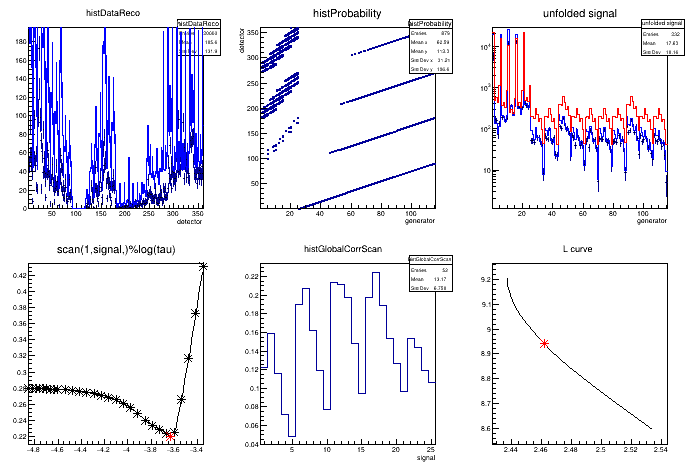

In [4]:
gROOT->GetListOfCanvases()->Draw()